In [1]:
# this notebook should be run on Google Colab
# matplotlib and seaborn used for plotting graphs
import warnings
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
from sklearn.metrics import mean_absolute_percentage_error
from scipy.signal import savgol_filter
from scipy.stats import zscore
from scipy.interpolate import pchip_interpolate
%matplotlib inline

warnings.filterwarnings("ignore")

In [2]:
def watt_to_dbm(df, target_column = 'power'):
    df['dbm'] = ((10*np.log10(df[target_column]) + 30)) # convert watts to dbm

    # df['dbm'].replace(np.nan, 0.0, inplace=True)
    min_without_inf = np.nanmin(df['dbm'][df['dbm'] != -np.inf])
    df['dbm'].replace(-np.inf, min_without_inf, inplace=True)


In [3]:
# rolling zscore function
def rolling_zscore(df, window = 5):
    std = df.rolling(window = window).std()
    mean = df.rolling(window = window).mean()
    z = (df - mean) / std
    return z


In [4]:
def smooth(df, window = 5, threshold = 1.0, target_column = 'dbm'):
    # std = df.rolling(window = window).std()
    # mean = df.rolling(window = window).mean()
    # print(std, mean)
 
    z = df.apply(lambda x: 0 if np.std(x) == 0 else rolling_zscore(x, window = window))

    print(df['id'].iloc[0], ' - ', df['tx'].iloc[0], '- z_min:', z[target_column].min(), 'z_max:', z[target_column].max())

    mask = (z[target_column] < -threshold) | (z[target_column] > threshold)
    df[f'{target_column}_copy'] = df[target_column]
    df.loc[mask, f'{target_column}_copy'] = np.nan
    df['interpolated'] = df[f'{target_column}_copy'].interpolate(method = 'cubic').astype(float)
    df['interpolated'].fillna(df[target_column], inplace = True)
    df['smooth'] = df[['interpolated']].apply(savgol_filter, window_length=101, polyorder=1)
    df['smooth'].fillna(df['interpolated'], inplace = True)
    df.drop([f'{target_column}_copy', 'interpolated'], axis = 1, inplace = True)
    return df   


In [10]:
filename = 'data.csv'
df = pd.read_csv(filename)
print(df.dtypes)

watt_to_dbm(df)

df_smooth = pd.DataFrame({})
for id in sorted(list(set(df['id']))):
    for tx in sorted(list(set(df[df['id'] == id]['tx']))):
        df_smooth = pd.concat([df_smooth, smooth(df.loc[(df['id'] == id) & (df['tx'] == tx)])])
print(np.nanmin(df_smooth['smooth'][df_smooth['smooth'] != -np.inf]))
df_smooth = df_smooth.groupby(['time', 'id', 'lon', 'lat'], as_index=False, sort=False)['smooth'].max()
min_without_inf = np.nanmin(df_smooth['smooth'][df_smooth['smooth'] != -np.inf])
df_smooth['smooth'].replace(-np.inf, min_without_inf, inplace=True)
df_smooth.to_csv(filename[:-4] + '_smooth.csv', index = False)
df_smooth


time     float64
id         int64
power    float64
lon      float64
lat      float64
tx         int64
dtype: object
1  -  0 - z_min: -1.7873929371616266 z_max: 1.7808038799521337
2  -  0 - z_min: -1.7888087300029754 z_max: 1.7863659176851572
3  -  0 - z_min: nan z_max: nan
4  -  0 - z_min: -1.7883557050185304 z_max: 1.748302399965474
5  -  0 - z_min: -1.7854430867723046 z_max: 1.7877833994741539
6  -  0 - z_min: nan z_max: nan
7  -  0 - z_min: nan z_max: nan
8  -  0 - z_min: -1.761257946784198 z_max: 1.7571912018783857
9  -  0 - z_min: -1.7886860406653842 z_max: 1.7888435467879755
10  -  0 - z_min: nan z_max: nan
11  -  0 - z_min: -1.7708610564296938 z_max: 1.7415690236527872
12  -  0 - z_min: -1.7883111109758647 z_max: 1.7887820092286366
13  -  0 - z_min: -1.7604255913949254 z_max: 1.6690996446252224
14  -  0 - z_min: -1.2841276463818938 z_max: -1.2447814461069286
15  -  0 - z_min: -1.279112133227707 z_max: -1.2543423722958502
16  -  0 - z_min: -1.7813171070822618 z_max: 1.77499010051

,time,id,lon,lat,smooth
0,0.00,1,3.057220,50.631858,-102.390289
1,0.02,1,3.057220,50.631858,-102.164882
2,0.04,1,3.057220,50.631858,-101.939476
3,0.06,1,3.057220,50.631858,-101.714070
4,0.08,1,3.057220,50.631858,-101.488663
...,...,...,...,...,...
27495,9.90,55,3.069958,50.636960,-76.589587
27496,9.92,55,3.069958,50.636960,-76.463745
27497,9.94,55,3.069958,50.636960,-76.337903
27498,9.96,55,3.069958,50.636960,-76.212060


In [16]:
df_single = df_smooth.loc[(df_smooth['id'] == 4)]
print(df_single['smooth'].max())
df_single


-83.3944772890439


,time,id,lon,lat,smooth
12003,0.00000,4,3.06863,50.630941,-135.142647
12004,0.02000,4,3.06863,50.630941,-133.507199
12005,0.04000,4,3.06863,50.630941,-131.871751
12006,0.06000,4,3.06863,50.630941,-130.236303
12007,0.08000,4,3.06863,50.630941,-128.600855
...,...,...,...,...,...
15999,79.92000,4,3.06863,50.630941,-135.347266
16000,79.93999,4,3.06863,50.630941,-135.314153
16001,79.96000,4,3.06863,50.630941,-135.281041
16002,79.98000,4,3.06863,50.630941,-135.247928


In [17]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [18]:
train, test = train_test_split(df_single, test_size=0.2)

In [19]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('power', fontsize=14)
    ax.set_xlabel('time', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

15890 -137.67451253944006


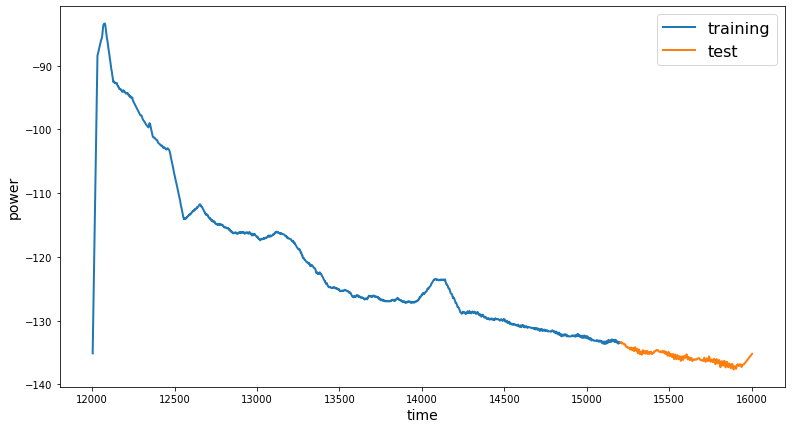

In [20]:
line_plot(train['smooth'], test['smooth'], 'training', 'test', title='')
print(df_single['smooth'].idxmin(), df_single['smooth'].min())


In [ ]:
def prepare_data(df, target_column, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = train_data['time']
    X_test = test_data['time']
    y_train = train_data[[target_column]]
    y_test = test_data[[target_column]]
    return train_data, test_data, X_train, X_test, y_train, y_test

In [ ]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape = (1, 1)))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [ ]:
# you can try different parameters if you want
random.seed(42)
test_size = 0.2
lstm_neurons = 500
epochs = 100
batch_size = 256
loss = 'mean_squared_error'
dropout = 0.05
optimizer = 'adam'

In [ ]:
train, test, X_train, X_test, y_train, y_test = prepare_data(df, 'smooth', test_size=test_size)

In [ ]:
model = build_lstm_model(X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss, optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, y_test), verbose=1, shuffle=True)

In [ ]:
def loss_function(model):
    plt.plot(model.history['loss'])
    plt.plot(model.history['val_loss'])
    plt.title("Model Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Test'])
    plt.show()

history.history.keys
loss_function(history)

In [ ]:
# cross-validation gives good-enough results
# calculate the error between the predicted values and the test set values

targets = test['smooth']
preds = model.predict(X_test).squeeze()
print('error:', round(mean_absolute_percentage_error(preds, y_test), 4), '%')

In [ ]:
preds = test['smooth'] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)